In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
tf.__version__

'2.2.0'

<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{nov} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [2]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- functions:
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batach to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network.
        - <b>return:</b>
            - <b>gen_los</b>: the batch loss in the generator network.
            - <b>dis_los</b>: the batch loss in the discriminator network.

In [14]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def train_step(self, sample, batch_size, loss_function, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = G(noise, training=True)

            real_output = D(X_train, training=True)
            fake_output = D(synthetic_data, training=True)

            gen_loss = my_binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(my_binary_cross_entropy(real_output, tf.ones_like(real_output)) + my_binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, loss_function, optimizerG, optimizerD):
        #reset the metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                gen_loss, dis_loss = self.train_step(batch, batch_size, loss_function, noise_input,
                                                    optimizerG, optimizerD)
                self.accumulated_dloss.append(dis_loss)
                self.accumulated_gloss.append(gen_loss)

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs, gen_loss,
                                                                          dis_loss, t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        


###  Test

In [15]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [16]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [17]:
X_train = tf.Variable(np.array(X_train))

In [18]:
G = Sequential()
G.add(Dense(50, input_shape=(50,)))
G.add(Dense(150))
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(32, input_shape=(9,)))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(Dense(32))
D.add(Dense(1, activation='sigmoid'))

In [19]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [20]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,50], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.32552958]], shape=(1, 1), dtype=float64)
loss of the D network: tf.Tensor(0.3938274602079615, shape=(), dtype=float64)


In [21]:
batch_size = 20
ep = 1700
noise_input = 50
optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [22]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, my_binary_cross_entropy, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.805471] :: D_loss[0.665477] :: time:0.554701[s]
epochs[1:1700] :: G_loss[0.737230] :: D_loss[0.686653] :: time:0.007907[s]
epochs[2:1700] :: G_loss[0.703836] :: D_loss[0.700570] :: time:0.007790[s]
epochs[3:1700] :: G_loss[0.751186] :: D_loss[0.699107] :: time:0.007692[s]
epochs[4:1700] :: G_loss[0.728084] :: D_loss[0.688671] :: time:0.007731[s]
epochs[5:1700] :: G_loss[0.714348] :: D_loss[0.699858] :: time:0.007929[s]
epochs[6:1700] :: G_loss[0.780579] :: D_loss[0.668855] :: time:0.007860[s]
epochs[7:1700] :: G_loss[0.697933] :: D_loss[0.698637] :: time:0.007611[s]
epochs[8:1700] :: G_loss[0.781362] :: D_loss[0.677803] :: time:0.007838[s]
epochs[9:1700] :: G_loss[0.725970] :: D_loss[0.683086] :: time:0.007902[s]
epochs[10:1700] :: G_loss[0.760577] :: D_loss[0.671279] :: time:0.007778[s]
epochs[11:1700] :: G_loss[0.773640] :: D_loss[0.656391] :: time:0.007854[s]
epochs[12:1700] :: G_loss[0.713285] :: D_loss[0.695418] :: time:0.007933[s]
epochs[13:1700] :: G_l

epochs[109:1700] :: G_loss[0.781827] :: D_loss[0.597657] :: time:0.013270[s]
epochs[110:1700] :: G_loss[0.771996] :: D_loss[0.593189] :: time:0.011991[s]
epochs[111:1700] :: G_loss[0.797104] :: D_loss[0.597572] :: time:0.010105[s]
epochs[112:1700] :: G_loss[0.744436] :: D_loss[0.620454] :: time:0.016454[s]
epochs[113:1700] :: G_loss[0.764066] :: D_loss[0.606900] :: time:0.011230[s]
epochs[114:1700] :: G_loss[0.779874] :: D_loss[0.605404] :: time:0.012372[s]
epochs[115:1700] :: G_loss[0.772026] :: D_loss[0.604168] :: time:0.014649[s]
epochs[116:1700] :: G_loss[0.749903] :: D_loss[0.620143] :: time:0.010009[s]
epochs[117:1700] :: G_loss[0.740796] :: D_loss[0.608523] :: time:0.010974[s]
epochs[118:1700] :: G_loss[0.747026] :: D_loss[0.614159] :: time:0.009055[s]
epochs[119:1700] :: G_loss[0.826638] :: D_loss[0.569076] :: time:0.007906[s]
epochs[120:1700] :: G_loss[0.781234] :: D_loss[0.594499] :: time:0.008113[s]
epochs[121:1700] :: G_loss[0.758085] :: D_loss[0.601854] :: time:0.007821[s]

epochs[232:1700] :: G_loss[0.817790] :: D_loss[0.589971] :: time:0.010249[s]
epochs[233:1700] :: G_loss[0.749299] :: D_loss[0.607278] :: time:0.009846[s]
epochs[234:1700] :: G_loss[0.899342] :: D_loss[0.554363] :: time:0.007823[s]
epochs[235:1700] :: G_loss[0.854897] :: D_loss[0.562966] :: time:0.008218[s]
epochs[236:1700] :: G_loss[0.733873] :: D_loss[0.633800] :: time:0.007889[s]
epochs[237:1700] :: G_loss[0.828262] :: D_loss[0.580182] :: time:0.009390[s]
epochs[238:1700] :: G_loss[0.913961] :: D_loss[0.551724] :: time:0.007868[s]
epochs[239:1700] :: G_loss[0.878859] :: D_loss[0.560226] :: time:0.007881[s]
epochs[240:1700] :: G_loss[0.926073] :: D_loss[0.534458] :: time:0.007938[s]
epochs[241:1700] :: G_loss[0.929600] :: D_loss[0.536910] :: time:0.007845[s]
epochs[242:1700] :: G_loss[0.843367] :: D_loss[0.576734] :: time:0.007899[s]
epochs[243:1700] :: G_loss[0.853528] :: D_loss[0.559953] :: time:0.007836[s]
epochs[244:1700] :: G_loss[0.890816] :: D_loss[0.557044] :: time:0.007817[s]

epochs[353:1700] :: G_loss[0.870298] :: D_loss[0.589240] :: time:0.009245[s]
epochs[354:1700] :: G_loss[0.944240] :: D_loss[0.533293] :: time:0.010642[s]
epochs[355:1700] :: G_loss[0.913164] :: D_loss[0.558390] :: time:0.008083[s]
epochs[356:1700] :: G_loss[0.971858] :: D_loss[0.517216] :: time:0.008719[s]
epochs[357:1700] :: G_loss[0.876488] :: D_loss[0.561959] :: time:0.008212[s]
epochs[358:1700] :: G_loss[0.843892] :: D_loss[0.602293] :: time:0.007984[s]
epochs[359:1700] :: G_loss[0.970937] :: D_loss[0.531820] :: time:0.008810[s]
epochs[360:1700] :: G_loss[0.888796] :: D_loss[0.582403] :: time:0.008151[s]
epochs[361:1700] :: G_loss[0.946633] :: D_loss[0.529067] :: time:0.007900[s]
epochs[362:1700] :: G_loss[0.892738] :: D_loss[0.562626] :: time:0.007812[s]
epochs[363:1700] :: G_loss[0.895874] :: D_loss[0.581358] :: time:0.008683[s]
epochs[364:1700] :: G_loss[0.955829] :: D_loss[0.531320] :: time:0.008017[s]
epochs[365:1700] :: G_loss[0.974725] :: D_loss[0.550416] :: time:0.007820[s]

epochs[468:1700] :: G_loss[0.968430] :: D_loss[0.548220] :: time:0.014863[s]
epochs[469:1700] :: G_loss[1.013263] :: D_loss[0.509168] :: time:0.010733[s]
epochs[470:1700] :: G_loss[0.748278] :: D_loss[0.636228] :: time:0.009222[s]
epochs[471:1700] :: G_loss[0.833265] :: D_loss[0.580347] :: time:0.010609[s]
epochs[472:1700] :: G_loss[1.032657] :: D_loss[0.512004] :: time:0.008599[s]
epochs[473:1700] :: G_loss[0.804342] :: D_loss[0.610595] :: time:0.008322[s]
epochs[474:1700] :: G_loss[0.929028] :: D_loss[0.560652] :: time:0.008969[s]
epochs[475:1700] :: G_loss[0.937818] :: D_loss[0.559477] :: time:0.009654[s]
epochs[476:1700] :: G_loss[0.978904] :: D_loss[0.525562] :: time:0.009177[s]
epochs[477:1700] :: G_loss[0.832296] :: D_loss[0.596104] :: time:0.008066[s]
epochs[478:1700] :: G_loss[0.826257] :: D_loss[0.610561] :: time:0.008424[s]
epochs[479:1700] :: G_loss[1.011156] :: D_loss[0.557588] :: time:0.009588[s]
epochs[480:1700] :: G_loss[0.909885] :: D_loss[0.588056] :: time:0.010610[s]

epochs[585:1700] :: G_loss[0.919104] :: D_loss[0.593207] :: time:0.013218[s]
epochs[586:1700] :: G_loss[0.928728] :: D_loss[0.589994] :: time:0.011519[s]
epochs[587:1700] :: G_loss[0.941772] :: D_loss[0.590267] :: time:0.008382[s]
epochs[588:1700] :: G_loss[1.058613] :: D_loss[0.531197] :: time:0.008118[s]
epochs[589:1700] :: G_loss[0.758213] :: D_loss[0.667122] :: time:0.008189[s]
epochs[590:1700] :: G_loss[0.901020] :: D_loss[0.589739] :: time:0.008015[s]
epochs[591:1700] :: G_loss[0.948231] :: D_loss[0.564949] :: time:0.007909[s]
epochs[592:1700] :: G_loss[0.938796] :: D_loss[0.563739] :: time:0.008510[s]
epochs[593:1700] :: G_loss[1.096132] :: D_loss[0.519950] :: time:0.008382[s]
epochs[594:1700] :: G_loss[0.937601] :: D_loss[0.570554] :: time:0.008713[s]
epochs[595:1700] :: G_loss[0.974169] :: D_loss[0.580097] :: time:0.008229[s]
epochs[596:1700] :: G_loss[0.887414] :: D_loss[0.589731] :: time:0.008392[s]
epochs[597:1700] :: G_loss[1.031829] :: D_loss[0.565581] :: time:0.008112[s]

epochs[705:1700] :: G_loss[0.926445] :: D_loss[0.603852] :: time:0.011263[s]
epochs[706:1700] :: G_loss[0.919132] :: D_loss[0.609260] :: time:0.010761[s]
epochs[707:1700] :: G_loss[0.923873] :: D_loss[0.599208] :: time:0.008852[s]
epochs[708:1700] :: G_loss[0.776611] :: D_loss[0.671825] :: time:0.009677[s]
epochs[709:1700] :: G_loss[0.790826] :: D_loss[0.680519] :: time:0.008445[s]
epochs[710:1700] :: G_loss[0.891769] :: D_loss[0.617555] :: time:0.008361[s]
epochs[711:1700] :: G_loss[0.879725] :: D_loss[0.612370] :: time:0.008035[s]
epochs[712:1700] :: G_loss[0.916160] :: D_loss[0.589773] :: time:0.008114[s]
epochs[713:1700] :: G_loss[0.945743] :: D_loss[0.584288] :: time:0.008081[s]
epochs[714:1700] :: G_loss[0.905254] :: D_loss[0.603252] :: time:0.007902[s]
epochs[715:1700] :: G_loss[0.782171] :: D_loss[0.659345] :: time:0.008108[s]
epochs[716:1700] :: G_loss[0.811931] :: D_loss[0.642017] :: time:0.008019[s]
epochs[717:1700] :: G_loss[0.938428] :: D_loss[0.602249] :: time:0.007901[s]

epochs[830:1700] :: G_loss[0.852295] :: D_loss[0.642796] :: time:0.009508[s]
epochs[831:1700] :: G_loss[0.908772] :: D_loss[0.620971] :: time:0.009320[s]
epochs[832:1700] :: G_loss[0.834938] :: D_loss[0.656076] :: time:0.008209[s]
epochs[833:1700] :: G_loss[0.801256] :: D_loss[0.654311] :: time:0.008305[s]
epochs[834:1700] :: G_loss[0.994377] :: D_loss[0.577361] :: time:0.008241[s]
epochs[835:1700] :: G_loss[0.921412] :: D_loss[0.623703] :: time:0.007993[s]
epochs[836:1700] :: G_loss[0.810857] :: D_loss[0.672807] :: time:0.007905[s]
epochs[837:1700] :: G_loss[0.913139] :: D_loss[0.652857] :: time:0.007850[s]
epochs[838:1700] :: G_loss[0.911179] :: D_loss[0.625806] :: time:0.007963[s]
epochs[839:1700] :: G_loss[0.884554] :: D_loss[0.626332] :: time:0.008001[s]
epochs[840:1700] :: G_loss[0.796428] :: D_loss[0.651691] :: time:0.008206[s]
epochs[841:1700] :: G_loss[0.991735] :: D_loss[0.601834] :: time:0.008166[s]
epochs[842:1700] :: G_loss[0.832134] :: D_loss[0.646414] :: time:0.007938[s]

epochs[949:1700] :: G_loss[0.831596] :: D_loss[0.658180] :: time:0.010883[s]
epochs[950:1700] :: G_loss[0.714789] :: D_loss[0.711281] :: time:0.014084[s]
epochs[951:1700] :: G_loss[0.784989] :: D_loss[0.677538] :: time:0.010121[s]
epochs[952:1700] :: G_loss[0.839592] :: D_loss[0.650971] :: time:0.008636[s]
epochs[953:1700] :: G_loss[0.784553] :: D_loss[0.679264] :: time:0.010443[s]
epochs[954:1700] :: G_loss[0.867317] :: D_loss[0.657417] :: time:0.008426[s]
epochs[955:1700] :: G_loss[0.880519] :: D_loss[0.628929] :: time:0.010196[s]
epochs[956:1700] :: G_loss[0.873957] :: D_loss[0.640476] :: time:0.008443[s]
epochs[957:1700] :: G_loss[0.911294] :: D_loss[0.635284] :: time:0.008791[s]
epochs[958:1700] :: G_loss[0.815479] :: D_loss[0.672480] :: time:0.009026[s]
epochs[959:1700] :: G_loss[0.855545] :: D_loss[0.640737] :: time:0.008211[s]
epochs[960:1700] :: G_loss[0.920876] :: D_loss[0.617976] :: time:0.008939[s]
epochs[961:1700] :: G_loss[0.833356] :: D_loss[0.650154] :: time:0.008646[s]

epochs[1070:1700] :: G_loss[0.758471] :: D_loss[0.695920] :: time:0.010785[s]
epochs[1071:1700] :: G_loss[0.792418] :: D_loss[0.671505] :: time:0.008692[s]
epochs[1072:1700] :: G_loss[0.878532] :: D_loss[0.641767] :: time:0.008238[s]
epochs[1073:1700] :: G_loss[0.785627] :: D_loss[0.678823] :: time:0.008185[s]
epochs[1074:1700] :: G_loss[0.781301] :: D_loss[0.689331] :: time:0.007966[s]
epochs[1075:1700] :: G_loss[0.892413] :: D_loss[0.653124] :: time:0.007919[s]
epochs[1076:1700] :: G_loss[0.741507] :: D_loss[0.696592] :: time:0.008161[s]
epochs[1077:1700] :: G_loss[0.793745] :: D_loss[0.675417] :: time:0.008120[s]
epochs[1078:1700] :: G_loss[0.812297] :: D_loss[0.662260] :: time:0.008067[s]
epochs[1079:1700] :: G_loss[0.774960] :: D_loss[0.683706] :: time:0.007956[s]
epochs[1080:1700] :: G_loss[0.907715] :: D_loss[0.633397] :: time:0.008076[s]
epochs[1081:1700] :: G_loss[0.802037] :: D_loss[0.671777] :: time:0.007898[s]
epochs[1082:1700] :: G_loss[0.825430] :: D_loss[0.661485] :: tim

epochs[1190:1700] :: G_loss[0.803710] :: D_loss[0.657320] :: time:0.009335[s]
epochs[1191:1700] :: G_loss[0.715645] :: D_loss[0.704353] :: time:0.010634[s]
epochs[1192:1700] :: G_loss[0.804926] :: D_loss[0.658396] :: time:0.008311[s]
epochs[1193:1700] :: G_loss[0.723003] :: D_loss[0.698893] :: time:0.008226[s]
epochs[1194:1700] :: G_loss[0.841234] :: D_loss[0.646818] :: time:0.008050[s]
epochs[1195:1700] :: G_loss[0.795602] :: D_loss[0.667354] :: time:0.008092[s]
epochs[1196:1700] :: G_loss[0.853956] :: D_loss[0.641968] :: time:0.007908[s]
epochs[1197:1700] :: G_loss[0.723842] :: D_loss[0.699352] :: time:0.008027[s]
epochs[1198:1700] :: G_loss[0.741504] :: D_loss[0.687952] :: time:0.007900[s]
epochs[1199:1700] :: G_loss[0.755596] :: D_loss[0.688854] :: time:0.007887[s]
epochs[1200:1700] :: G_loss[0.796239] :: D_loss[0.669179] :: time:0.008056[s]
epochs[1201:1700] :: G_loss[0.783414] :: D_loss[0.679451] :: time:0.008184[s]
epochs[1202:1700] :: G_loss[0.831765] :: D_loss[0.650168] :: tim

epochs[1314:1700] :: G_loss[0.728231] :: D_loss[0.686432] :: time:0.009725[s]
epochs[1315:1700] :: G_loss[0.808524] :: D_loss[0.653699] :: time:0.010022[s]
epochs[1316:1700] :: G_loss[0.841996] :: D_loss[0.642063] :: time:0.008483[s]
epochs[1317:1700] :: G_loss[0.787113] :: D_loss[0.665772] :: time:0.008591[s]
epochs[1318:1700] :: G_loss[0.744550] :: D_loss[0.679866] :: time:0.008507[s]
epochs[1319:1700] :: G_loss[0.781975] :: D_loss[0.666816] :: time:0.009328[s]
epochs[1320:1700] :: G_loss[0.755493] :: D_loss[0.674559] :: time:0.009515[s]
epochs[1321:1700] :: G_loss[0.824024] :: D_loss[0.645846] :: time:0.008506[s]
epochs[1322:1700] :: G_loss[0.683859] :: D_loss[0.705063] :: time:0.010126[s]
epochs[1323:1700] :: G_loss[0.756988] :: D_loss[0.673528] :: time:0.009957[s]
epochs[1324:1700] :: G_loss[0.756778] :: D_loss[0.676599] :: time:0.009537[s]
epochs[1325:1700] :: G_loss[0.781910] :: D_loss[0.667755] :: time:0.009609[s]
epochs[1326:1700] :: G_loss[0.783710] :: D_loss[0.664547] :: tim

epochs[1430:1700] :: G_loss[0.724702] :: D_loss[0.673941] :: time:0.008892[s]
epochs[1431:1700] :: G_loss[0.748542] :: D_loss[0.666935] :: time:0.010011[s]
epochs[1432:1700] :: G_loss[0.743107] :: D_loss[0.666906] :: time:0.008592[s]
epochs[1433:1700] :: G_loss[0.720491] :: D_loss[0.676898] :: time:0.008045[s]
epochs[1434:1700] :: G_loss[0.733389] :: D_loss[0.674351] :: time:0.008044[s]
epochs[1435:1700] :: G_loss[0.765452] :: D_loss[0.658974] :: time:0.008444[s]
epochs[1436:1700] :: G_loss[0.722936] :: D_loss[0.677967] :: time:0.008430[s]
epochs[1437:1700] :: G_loss[0.714444] :: D_loss[0.678942] :: time:0.008062[s]
epochs[1438:1700] :: G_loss[0.775009] :: D_loss[0.656633] :: time:0.008682[s]
epochs[1439:1700] :: G_loss[0.698608] :: D_loss[0.691874] :: time:0.008276[s]
epochs[1440:1700] :: G_loss[0.766544] :: D_loss[0.665475] :: time:0.008035[s]
epochs[1441:1700] :: G_loss[0.778150] :: D_loss[0.658348] :: time:0.007921[s]
epochs[1442:1700] :: G_loss[0.819494] :: D_loss[0.642130] :: tim

epochs[1545:1700] :: G_loss[0.724401] :: D_loss[0.677882] :: time:0.009763[s]
epochs[1546:1700] :: G_loss[0.787211] :: D_loss[0.650476] :: time:0.011557[s]
epochs[1547:1700] :: G_loss[0.775405] :: D_loss[0.653627] :: time:0.008340[s]
epochs[1548:1700] :: G_loss[0.766284] :: D_loss[0.659345] :: time:0.009471[s]
epochs[1549:1700] :: G_loss[0.741042] :: D_loss[0.667406] :: time:0.008326[s]
epochs[1550:1700] :: G_loss[0.794039] :: D_loss[0.648175] :: time:0.008209[s]
epochs[1551:1700] :: G_loss[0.753600] :: D_loss[0.659518] :: time:0.007922[s]
epochs[1552:1700] :: G_loss[0.741512] :: D_loss[0.669090] :: time:0.008136[s]
epochs[1553:1700] :: G_loss[0.814958] :: D_loss[0.636843] :: time:0.008156[s]
epochs[1554:1700] :: G_loss[0.774752] :: D_loss[0.652018] :: time:0.007923[s]
epochs[1555:1700] :: G_loss[0.740806] :: D_loss[0.664080] :: time:0.008051[s]
epochs[1556:1700] :: G_loss[0.805628] :: D_loss[0.642595] :: time:0.008103[s]
epochs[1557:1700] :: G_loss[0.738590] :: D_loss[0.663565] :: tim

epochs[1669:1700] :: G_loss[0.799334] :: D_loss[0.642657] :: time:0.009623[s]
epochs[1670:1700] :: G_loss[0.765728] :: D_loss[0.655623] :: time:0.010777[s]
epochs[1671:1700] :: G_loss[0.710475] :: D_loss[0.684030] :: time:0.008350[s]
epochs[1672:1700] :: G_loss[0.745613] :: D_loss[0.669377] :: time:0.008454[s]
epochs[1673:1700] :: G_loss[0.812701] :: D_loss[0.642212] :: time:0.008109[s]
epochs[1674:1700] :: G_loss[0.760874] :: D_loss[0.657171] :: time:0.008083[s]
epochs[1675:1700] :: G_loss[0.813250] :: D_loss[0.636384] :: time:0.007988[s]
epochs[1676:1700] :: G_loss[0.783564] :: D_loss[0.648171] :: time:0.007954[s]
epochs[1677:1700] :: G_loss[0.746502] :: D_loss[0.660912] :: time:0.008179[s]
epochs[1678:1700] :: G_loss[0.791964] :: D_loss[0.641541] :: time:0.007900[s]
epochs[1679:1700] :: G_loss[0.796686] :: D_loss[0.646298] :: time:0.007846[s]
epochs[1680:1700] :: G_loss[0.775532] :: D_loss[0.653497] :: time:0.007899[s]
epochs[1681:1700] :: G_loss[0.781314] :: D_loss[0.646569] :: tim

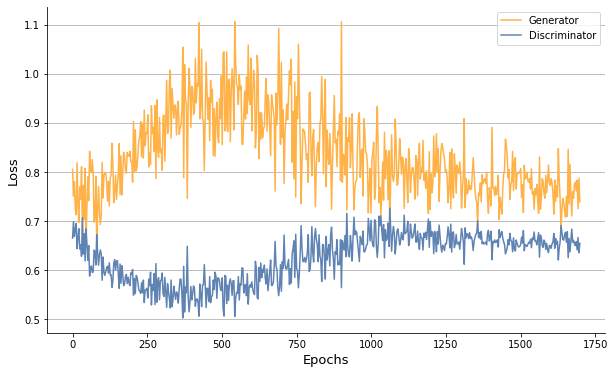

In [23]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

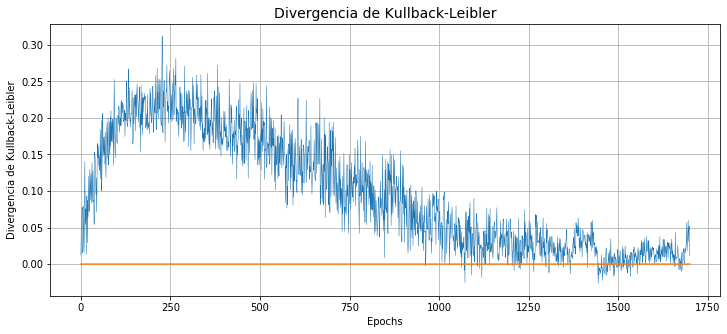

In [25]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");